# This file contains 3 different components as following:

##1. Feature Extractions (Pattern of Life, TF-IDF, LIWC)

##2. Classifier training and model dumping(storage) 

##3. Evaluations of Model (10-fold CV, selection bias test,  limited tweets test)

In [2]:
%load_ext autoreload
%autoreload 2
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
from tabulate import tabulate
import age_gender_predictor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import Imputer
import age_gender_predictor
import json
%matplotlib inline
from pylab import rcParams
from random import randint
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import vstack
rcParams['figure.figsize'] = 10, 7
from operator import itemgetter 
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import preprocessing
import time
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from tabulate import tabulate

In [3]:
# Data Fetching, transformation and filtering


def getLangRatio(cursor):
    lang_ratios = {}
    for tweet in cursor:
        lang = 1 if tweet["lang"] == "en" else 0
        user_id = tweet["user"]["id"]
        if user_id in lang_ratios:
            lang_ratios[user_id].append(lang)
        else:
            lang_ratios[user_id] = [lang]
    for user_id, ratio in lang_ratios.items():
        lang_ratios[user_id] = np.sum(ratio) / len(ratio)
    return lang_ratios
                                   

def getUsersTweets(dbName,collectionName, en_threshold=0.9):
    cursor = MongoClient("localhost", 27017)[dbName][collectionName].find()
    lang_ratios = getLangRatio(cursor)

    cursor = MongoClient("localhost", 27017)[dbName][collectionName].find()
    usersTweets = {}
    for tweet in cursor:
        userID = tweet["user"]["id"]
        if lang_ratios[userID] < en_threshold:
            continue
        #Processing emotions from Carlos' API
        emotion =  tweet["emotion"]["groups"][0]["name"]
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]
            
        ambiguous = True if tweet['emotion']['ambiguous'] == 'yes' else False
       
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]    
        else:
            emotion_2 = None
        if tweet["polarity"] == "positive":
            polarity = 1
        elif tweet["polarity"] == "negative":
            polarity = -1
        else:
            polarity = 0
   
            
        date = tweet["created_at"]
        text = tweet['text']

        if userID not in usersTweets:
            usersTweets[userID] = {}
        if date not in usersTweets[userID]:
            usersTweets[userID][date] = {}
            
        usersTweets[userID][date]['text'] = text
        usersTweets[userID][date]['polarity'] =  polarity
        usersTweets[userID][date]['emotion'] =  emotion
        usersTweets[userID][date]['emotion_2'] =  emotion_2
        usersTweets[userID][date]['ambiguous'] =  ambiguous
    return usersTweets



def timeSeriesTransform(usersEmotions):
    for userID in usersEmotions:
        usersEmotions[userID] = pd.DataFrame.from_dict(usersEmotions[userID], orient='index').fillna(0)
        usersEmotions[userID]['dt'] = np.zeros(usersEmotions[userID].shape[0],dtype=float)
        usersEmotions[userID].loc[:-1,'dt'] = (usersEmotions[userID].index[1:].values - usersEmotions[userID].index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return list(usersEmotions.values())


def getHTTPRows(timeSeries):
    count = 0
    patterns = ['http://','https://']
    conditions = timeSeries['text'].str.contains(patterns[0])
    for pattern in patterns[1:]:
        conditions = conditions | timeSeries['text'].str.contains(pattern)

    return conditions.values

def userFilter(group, spam_threshold=0.5,tweets_threshold=100):    #Spam and inactive user filter
    new_group = []
    for timeSeries in group:
        http_rows = getHTTPRows(timeSeries)
        average_http_count = np.sum(http_rows) / timeSeries.shape[0]
        if (average_http_count < spam_threshold) and (timeSeries.shape[0] > tweets_threshold):
            new_group.append(timeSeries)
    return new_group




In [15]:
def getCategories(group):
    name2category = {}
    names = ["Social", "Emotions", "Polarity", "LIWC", "AgeGender"]
    methods = [getSocialFeature_group, getGroupEmotions, getPolarity, getLIWC_group, getAgeGender]
    for i, method in enumerate(methods):
        if method == getLIWC_group:
            feature = {"LIWC_"+key: value for key, value in method([group.group[0]]).items()}

        else:
            feature = method([group.group[0]])
        for key in feature:
            name2category[key] = names[i]
    return name2category

#Functions for LIWC and POL features extraction:
def loads_LIWC():
    f = open("../4_prediction_visualization/categories.json", 'r')
    categories = json.load(f)
    f = open("../4_prediction_visualization/words.json", 'r')
    words = json.load(f)
    patterns_categories = {}
    for word, category in words.items():
        if word[-1] == '*':
            current_dict = patterns_categories
            for char in word:
                if char == '*':
                   
                    #current_dict = category
                    pre_dict[word[-2]] = category
                    break
                
                elif char not in current_dict:
                    current_dict[char] = {}
                pre_dict = current_dict
                current_dict = current_dict[char]
                
    return categories, words, patterns_categories
LIWC_categories, LIWC_words, LIWC_patterns_categories = loads_LIWC() 

def getLIWC_user(timeSeries):
 
    LIWC_counts = {}
    
 
    features = np.zeros(len(LIWC_categories),dtype=int)
    
    texts= timeSeries["text"].values
    for text in texts:
        words = text.strip().split()
        for word in words:
            category_indices = LIWC_words.get(word,[])
            if category_indices == []:
                current_dict = LIWC_patterns_categories
                for char in word[:-1]:
                    current_dict = current_dict.get(char,[])
                    if isinstance(current_dict,list):
                        category_indices = current_dict                            
                        break


            for category_index in category_indices:

                category_name = LIWC_categories[category_index]

                LIWC_counts[category_name] = LIWC_counts.get(category_name,0) + 1

    for category_name in LIWC_counts:
        LIWC_counts[category_name] /= timeSeries.shape[0]
    
    return LIWC_counts

def getLIWC_group(group):
    LIWC_counts = {}
    users_num = len(group)
    for category in LIWC_categories.values():
        LIWC_counts[category] = []
    for timeSeries in group:
        user_LIWC_count = getLIWC_user(timeSeries)
      
        for category in LIWC_categories.values():
          
            LIWC_counts[category].append(user_LIWC_count.get(category,0))
            
    
    
    return LIWC_counts

#polarity
def getFlipsCount(timeSeries, upperbound=60, lowerbound = 0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    return np.sum((durations > lowerbound) & (durations < upperbound) )



def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips


def getFlipsDuration(timeSeries, flips):
    filtered_timeSeries = timeSeries['dt'][flips].index.values
    dt = np.zeros(filtered_timeSeries.shape[0],dtype=float)
    dt[:-1] = (filtered_timeSeries[1:] - filtered_timeSeries[:-1]).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return dt

def getCombosCount(timeSeries, matcher = -1, lowerbound = 2):
    combos = comboTracker(timeSeries)
    combos_count = sum([hit for element, hit, index in combos if element == matcher and hit > lowerbound])
    return combos_count

def comboTracker(timeSeries, attribute= "polarity", time_threshold=120):
    array = timeSeries[attribute]
    starter = array[0]
    combo = 1
    result = []
    index = 0
    for cursor in array[1:]:
        index +=1
        if starter == cursor and timeSeries["dt"][index-1] < time_threshold:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo,index-combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo, index-combo))
    return result

def getNegativeRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == -1) / total_tweets


def getPositiveRatio(timeSeries):
    total_tweets = timeSeries.shape[0]
    return np.sum(timeSeries["polarity"].values == 1) / total_tweets





def getPolarity(group):
    polarity = {"flips":[],"negative_combos":[],"positive_combos":[], "positive_ratio":[], "negative_ratio":[]}
    for timeSeries in group:
        tweets_length = timeSeries.shape[0]
        flips_ratio = getFlipsCount(timeSeries) / tweets_length
        negative_combos_ratio = getCombosCount(timeSeries,matcher=-1) / tweets_length
        positive_combos_ratio = getCombosCount(timeSeries,matcher=1) / tweets_length
        positive_ratio = getPositiveRatio(timeSeries)
        negative_ratio = getNegativeRatio(timeSeries)
        
        polarity["flips"].append(flips_ratio)
        polarity["negative_combos"].append(negative_combos_ratio)
        polarity["positive_combos"].append(positive_combos_ratio)
        polarity["positive_ratio"].append(positive_ratio)
        polarity["negative_ratio"].append(negative_ratio)
        
    return polarity


#Emotions Table


def getUsersEmotions(timeSeries):
    non_ambiguous = np.invert(timeSeries["ambiguous"].values)
    filtered_emotions = timeSeries["emotion"][non_ambiguous].values
    emotions_count = {"joy":0,"sadness": 0,"fear":0,\
                "anticipation": 0, "anger":0, "trust": 0, "disgust": 0 ,"surprise" : 0}
    for emotion in emotions_count:
        emotions_count[emotion] = np.sum(filtered_emotions == emotion) / filtered_emotions.shape[0]
    return emotions_count
        


def getGroupEmotions(group):
    emotions_counts = {"joy":[],"sadness": [],"fear":[],\
                "anticipation": [], "anger":[], "trust": [], "disgust": [] ,"surprise" : []}
    for timeSeries in group:
        emotions_count = getUsersEmotions(timeSeries)
        for emotion, count in emotions_count.items():
            emotions_counts[emotion].append(count)
    return emotions_counts
#social features
def getTweetRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    delta_time = np.max(timeSeries.index.values) - np.min(timeSeries.index.values)
    totla_duration = (delta_time).astype('timedelta64[h]') / np.timedelta64(24, 'h')
    return total_tweets / totla_duration
def getMentioRate(timeSeries):
    total_tweets = timeSeries.shape[0]
    total_mentions = np.sum(seriesContains(timeSeries))
    return total_mentions / total_tweets


def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False

def seriesContains(timeSeries):
    match_function = np.vectorize(thirdPronuonDetect)


    return match_function(timeSeries["text"].str.lower().str.split().values)


def getUniqueMentions(timeSeries):
    total_tweets = timeSeries.shape[0]
    friends_set = set()
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_set.add(word)
    return len(friends_set)

def getFrequentMentions(timeSeries, lowerbound = 3):
    total_tweets = timeSeries.shape[0]
    friends_mentions = {}
    texts = timeSeries["text"].values
    for text in texts:
        terms = text.strip().split()
        for word in terms:
            if word[0] == '@' and len(word) > 1:
                friends_mentions[word] = friends_mentions.get(word, 0) +1
    frequent_frients = [screen_name for screen_name, mentions in friends_mentions.items() if mentions >= lowerbound]
    return len(frequent_frients)
 

def getSocialFeature_group(group):
    social_features = {"tweets_rate": [],"mention_rate": [],"unique_mentions": [],"frequent_mentions": []}
    for timeSeries in group:
        social_features["tweets_rate"].append(getTweetRate(timeSeries))
        social_features["mention_rate"].append(getMentioRate(timeSeries))
        social_features["unique_mentions"].append(getUniqueMentions(timeSeries))
        social_features["frequent_mentions"].append(getFrequentMentions(timeSeries))
    return social_features

def getAllFeature(group, tail_k = "all"):
    feature_set = {}
    methods = [getSocialFeature_group, getGroupEmotions, getPolarity, getLIWC_group, getAgeGender]
    for method in methods:
        if method == getLIWC_group:
            LIWC_feature_set = {"LIWC_"+key: value for key, value in method(group.getGroup(tail_k)).items()}
            feature_set.update(LIWC_feature_set)
        else:
            feature_set.update(method(group.getGroup(tail_k)))
    return feature_set

#Age and gender Distribution

def getAgeGender(group):
    features = {"age":[],"gender":[]}
    for timeSeries in group:
        
        features["age"].append(getAge(timeSeries))
        features["gender"].append(getGender(timeSeries))

    return features
def getAge(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_age(texts)

def getGender(timeSeries):
    texts = ""
    for text in timeSeries["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_gender(texts)

In [8]:
# The users are wrapped into class package. Group class stores a list of Pandas time frame.


class Group(object):
    
    
    
    def __init__(self, name, group=None, spam_threshold=0.5, tweets_threshold=100, **kwargs):
        self.name = name
        
        dbName  = kwargs.get("dbName", None)
        collectionName  = kwargs.get("collectionName", None)
        
        if dbName is None or collectionName is None:
            self.group = group
        else:

            self.group = userFilter(timeSeriesTransform(getUsersTweets(dbName,collectionName)), spam_threshold=spam_threshold, tweets_threshold=tweets_threshold)
        
 
        
    def getTexts(self, tail_k = "all"):
        if tail_k == "all":
            return ["\n".join(timeSeries["text"].values) for timeSeries in self.group]
        else:
            return ["\n".join(timeSeries["text"].tail(tail_k).values) for timeSeries in self.group]

    
    def getName(self):
        return self.name
    def getSize(self):
        return len(self.group)
    def __repr__(self):
        return repr(self.group)
    def __add__(self, other):
        return Group(self.name, self.group + other.group)
    
    def getGroup(self,tail_k="all"):
        if tail_k == "all":
            return self.group
        else:
            return [timeSeries.tail(tail_k) for timeSeries in self.group]
    
    
    def __iadd__(self, other):
        self.group += other.group
        return self    
    





# Fetching the data from MongoDB

#Randomly sampled users
regular_group = Group("Random Samples",dbName = "idea",collectionName="regularUser_en_fixed_emotion")


# Data of patients
bipolar_group_clean = Group("Bipolar",dbName ="patients", collectionName="bipolar_clean")
BPD_group_clean = Group("BPD",dbName = "patients",collectionName="BPD_clean")

#people have both disorder
mix_group = Group("Mix", dbName = "patients",collectionName="bb_mix")


# EVERY user that has BPD
BPD_all = BPD_group_clean + mix_group
# EVERY user that havs Bipolar
bipolar_all = bipolar_group_clean + mix_group



#Disorder Experts
bipolar_experts =  Group("bipolar Expert", dbName= "patients", collectionName="bipolar_experts", spam_threshold=0.55)
BPD_experts =  Group("BPD Expert", dbName="idea", collectionName="coach_tweets_emotion", spam_threshold=0.55)


In [9]:
# This is how a patient's pandas frame looks like:

BPD_all.group[0]

,emotion_2,text,emotion,polarity,ambiguous,dt
2011-05-22 23:51:56,anger,wants to start writing for radio or tv...or th...,anticipation,0,False,6660.933333
2011-05-27 14:52:52,joy,Is sitting in #theangelcentre bored out of her...,disgust,-1,True,28573.800000
2011-06-16 11:06:40,disgust,Can't believe I got stung by a wasp! I haven't...,sadness,-1,False,2807.516667
2011-06-18 09:54:11,0,@PollyThorpe I am now addicted to Fourrooms! T...,joy,0,False,59807.733333
2011-07-29 22:41:55,surprise,My blog has begun. Check out www.lucydavisreta...,joy,1,False,319756.800000
2012-03-07 23:58:43,joy,Enjoyed watching @SdeBurca1 at #thegreylady #t...,trust,1,False,57262.516667
2012-04-16 18:21:14,sadness,@_Burchell you're always lookin' like a #pikey xx,joy,1,True,3362.150000
2012-04-19 02:23:23,disgust,@_Burchell how could I forget!,sadness,0,False,3374.866667
2012-04-21 10:38:15,disgust,"Oh dear, I've only just got up and my eyelids ...",anger,-1,False,33703.083333
2012-05-14 20:21:20,0,@_Burchell won't love me tonight :(,sadness,0,False,6.233333


### The TF-IDF models are trained in the following class

In [13]:
#A TF-IDF class to implement TF-IDF extraction and model training.



def XYGenerator(labeled_data):
    X, Y = labeled_data[0]
    

    
    for x, y in labeled_data[1:]:
        try:
            
            X = np.concatenate((X, x))
        except:
            X = vstack([X, x])
            
        Y = np.concatenate((Y, y))
    
   
    
    
    return X, Y


class TextFeatureGroups(object):
    
    def __init__(self, base, groups, model = "Tf-iDF"):
        self.base = base
        self.groups = groups
        self.name_to_index = {group.getName(): index for index, group in enumerate(groups)}
       
        base_texts = base.getTexts()
        self.text_models = []
        self.classifiers = []
        for group in groups:
            group_texts = group.getTexts()
            total_texts = base_texts  + group_texts
            if model == "Tf-iDF":
                text_model = TfidfVectorizer(stop_words="english",ngram_range = (1,2))
            text_model.fit(total_texts)    
            X = text_model.fit_transform(total_texts)  
            Y = np.array([0] * base.getSize() + [1]*group.getSize(), dtype=int)
            classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
            classifier.fit(X,Y)
            self.classifiers.append(classifier)
            self.text_models.append(text_model)
    
    

        
    

    
    def getTopFeatures(self, name, k=50):
        index = self.name_to_index[name]
        text_model = self.text_models[index]
        classifier = self.classifiers[index]
        feature_indicies = np.argsort(classifier.feature_importances_)
        vector2word = text_model.get_feature_names()
        top_words = []
        for i in range(k):
            vector = feature_indicies[-i-1]
            word = vector2word[vector]
            top_words.append(word)
        return top_words
            
            
        
        
    
    
    

    def getGroup(self,name):
        index = self.name_to_index[name]
        return self.group[index]
            
    def classify(self,name, group):
        index = self.name_to_index[name]
        classifier = self.classifiers[index]
        text_model = self.text_models[index]
        X = text_model.transform(group.getTexts())
        return classifier.predict(X) 
    
    def getPrecision(self,name, tail_k="all", classifier = "default", n_fold=10):
        index = self.name_to_index[name]
        group = self.groups[index]
        if classifier == "default":
            classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        #classifier = SVC(probability=True)
        #X = self.text_models[index].transform(self.base.getTexts(tail_k)+group.getTexts(tail_k))
        text_model = self.text_models[index]
        raw_X = self.base.group + group.group
        Y =  np.array([0] * self.base.getSize() + [1] * group.getSize())
        precisions = []
        
        complete_X = text_model.transform(self.base.getTexts()+group.getTexts())
        tailed_X =  text_model.transform(self.base.getTexts(tail_k)+group.getTexts(tail_k))
        
        
        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

        for train_index, test_index in sss:
            
            X_train, X_test = complete_X[train_index], tailed_X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            classifier.fit(X_train, Y_train)
            score = classifier.score(X_test,Y_test)
            precisions.append(score)

        return np.mean(precisions)
        
    
    def getLabelsScores(self, name, classifier,n_fold):
        index = self.name_to_index[name]
        group = self.groups[index]

        SCORES = np.array([])
        LABELS = np.array([])


        X = self.text_models[index].transform(self.base.getTexts()+group.getTexts())
        Y =  np.array([0] * self.base.getSize() + [1] * group.getSize())
        

        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

        for train_index, test_index in sss:

            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))

        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test)


        
    def renderPrecisionRecall(self,colors=['r','g','b',"y","w"], n_fold = 10):
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.title.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')

        for g, group in enumerate(self.groups):

            SCORES, LABELS,(X_train, X_test,Y_train, Y_test) = self.getLabelsScores(group.getName(), classifier ,n_fold)
   
            

            precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS, SCORES)






            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test


            print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,group.getName()))
            print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,group.getName()))
            plt.plot(recall, precision, label=group.getName() , color=colors[g],linewidth=3)

        plt.legend(loc="lower right")
        plt.show()

            
        
        
            
        

# Build the TF-IDF class

tfidf_groups = TextFeatureGroups(regular_group, [bipolar_all,BPD_all])



# Extract Top 10 keywords by TF-IDF model for Bipolar and BPD
bipolar_words = tfidf_groups.getTopFeatures("Bipolar")
BPD_words = tfidf_groups.getTopFeatures("BPD")

print(bipolar_words)
print("\n\n")

print(BPD_words)




['hugs', 'mental illness', 'bipolar', 'mania', 'stigma', 'mentalhealth bipolar', 'thoughts', 'help', 'awareness', 'bipolar disorder', 'bpd', 'suicide', 'electroboyusa', 'dealing', 'mentalhealth mentalillness', 'mh', 'disorder http', 'manic', 'mental health', 'bipolar depression', 'lithium', 'stable', 'bipolar_blogs', 'happy birthday', 'self', 'hospital', 'funniest', 'share', 'health care', 'recovery http', 'illness', 'mentalillness', 'illnesses', 'bipolardisorder', 'difficult', 'insomnia', 'bipolar http', 'therapy', 'support', 'medication', 'selfharm', 'mental', 'post', 'yo', 'bipolarblogger', 'self harm', 'anxiety', 'mentalhealth', 'heal', 'doc']



['mh', 'illness', 'mindfulness', 'harm', 'diagnosed', 'bpd', 'bpd http', 'therapy', 'mental illness', 'support', 'difficult', 'triggers', 'medication', 'therapist', 'borderline', 'suicidal', 'feel', 'bipolar', 'inpatient', 'distract', 'bipolarblogger', 'personality', 'health', 'control', 'symptoms', 'bpd bipolar', 'paranoid', 'patients', '

### The Pattern of Life model and LIWC models are trained in the following class

493 Normal and 284 Bipolar in Training Data
55 Normal and 32 Bipolar in Test Data



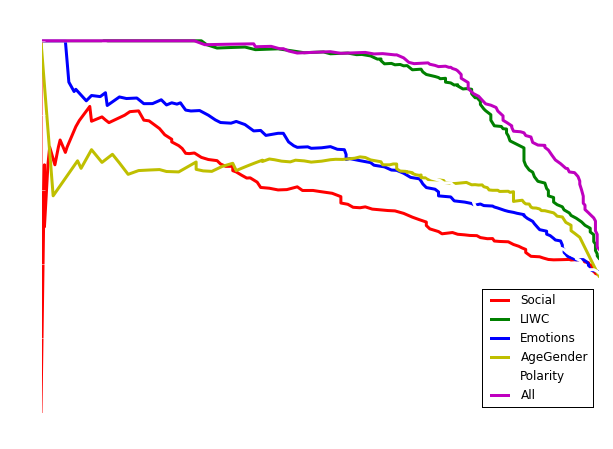

493 Normal and 217 BPD in Training Data
55 Normal and 24 BPD in Test Data



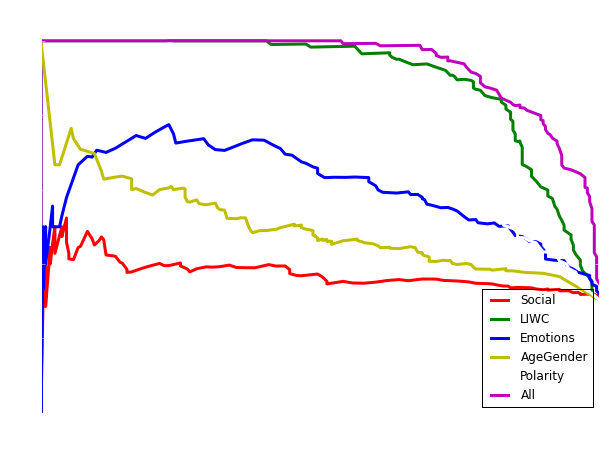

In [16]:
# This class wrap the normal users Group and patients Group, it renders performance and calculate the precisions.






class POLFeaturerGroups(object):
    
    @staticmethod
    def transform(self, ):
        features_dict = getAllFeature(group)
        
    
    def __init__(self, base, groups):
        feature2categories = getCategories(base)
        self.groups = groups
        self.base = base
        self.categories = set(feature2categories.values())
        self.name_to_index = {group.getName(): index for index, group in enumerate(groups)}
        self.base_name = base.getName()
        self.index2feature = []
        base_feature_dict = getAllFeature(base)
        self.base_feature = np.zeros((base.getSize(),len(base_feature_dict)), dtype = float)
        for name, values in base_feature_dict.items():
            cursor = len(self.index2feature)
          
            self.base_feature[:,cursor] = values
            category = feature2categories[name]
            self.index2feature.append((name, category))
        

        self.features = [self.group2feature(group) for group in groups]
    
    def group2feature(self, group, tail_k="all", selection = "all"):

        features_dict = getAllFeature(group, tail_k)
        feature = np.zeros((group.getSize(),len(self.index2feature)),dtype=float)
        for cursor, (name,category) in enumerate(self.index2feature):
            value = features_dict[name]
            feature[:,cursor] = value
            
        if selection == "all":
            return feature
        else:
            return feature[:,selection]
        
        
        

    def getPrecision(self,name,selection="all",tail_k="all",n_fold=10,classifier = "forest"):
        complete_X, Y = self.getLabeledData(name, selection)
        index = self.name_to_index[name]
        group = self.groups[index]
        tailed_X = preprocessing.scale(self.group2feature(self.base + group, tail_k=tail_k, selection = selection))
        complete_X = preprocessing.scale(complete_X)
        
        tailed_X[np.isinf(tailed_X)] = 0
        tailed_X[np.isnan(tailed_X)] = 0
        
        precisions = []
        if classifier == "forest":
            classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
  
        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

        for train_index, test_index in sss:

            X_train, X_test = complete_X[train_index], tailed_X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            imputer = Imputer()
        
            classifier.fit(X_train, Y_train)
            score = classifier.score(X_test,Y_test)
            precisions.append(score)
           
            
        return np.mean(precisions)
            
        
        
    def getLabeledData(self,name, selection = "all"):
        if selection is "all":
            selection = range(len(self.index2feature))
        
        base_feature = self.base_feature[:,selection]
        base_length = base_feature.shape[0]
        index = self.name_to_index[name]
        feature = self.features[index][:,selection]

        X = np.zeros((base_length  + feature.shape[0],len(selection)),dtype=float)
        X[0:base_length ,:] = base_feature
        X[base_length:,:] = feature
        Y = np.array([0]*base_length  + [1]*feature.shape[0])
        
        return X, Y
        
    
      
    def getFeatureImportances(self,name, seleciton):
        X, Y = self.getLabeledData(name, seleciton)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        features_indicies = np.argsort(classifier.feature_importances_)
        feature_names = [self.index2feature[i] for i in features_indicies ]
        return feature_names[::-1]
    
    
    def getFeatureImportance_all(self,name):
        X, Y = self.getLabeledData(name)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        features_indicies = np.argsort(classifier.feature_importances_)
        feature_names = [self.index2feature[i] for i in features_indicies ]
        return feature_names[::-1]
    
    def getFeature(self, name, selection="all"):
        if selection is "all":
            selection = list(range(len(self.index2feature)))
        index = self.name_to_index[name]
        feature =  self.features[index]
        return feature[:, selection]
        
    
    
    def classify(self,name, target_name, selection="all"):
        X, Y = self.getLabeledData(name, selection)
        classifier = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        classifier.fit(X,Y)
        test_x = self.getFeature(target_name,selection)
        return classifier.predict(test_x)
    
    def getLabelsScores_limited(self, name, classifier,n_fold, selection,limitation):
        SCORES = np.array([])
        LABELS = np.array([])
        
        X, Y = self.getLabeledData(name, selection)
        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

        for train_index, test_index in sss:

            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))

        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test)
    


    
    def getLabelsScores_multiClassifiers(self, name, classifiers,n_fold, selection):
        SCORES = []
        LABELS = []
        for i in range(len(classifiers)):
            
            SCORES.append(np.array([]))
            LABELS.append(np.array([]))
        
        X, Y = self.getLabeledData(name, selection)
        X = preprocessing.scale(X)
        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

        for train_index, test_index in sss:

            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            for i, classifier in enumerate(classifiers):

                classifier.fit(X_train, Y_train)
                score = classifier.predict_proba(X_test)[:,1]
                SCORES[i] = np.concatenate((SCORES[i], score))
                LABELS[i] = np.concatenate((LABELS[i], Y_test))

        return SCORES, LABELS
        
    def getLabelsScores(self, name, classifier,n_fold, selection):
        SCORES = np.array([])
        LABELS = np.array([])
        
        X, Y = self.getLabeledData(name, selection)
        sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )

        for train_index, test_index in sss:

            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            classifier.fit(X_train, Y_train)
            score = classifier.predict_proba(X_test)[:,1]
            SCORES = np.concatenate((SCORES, score))
            LABELS = np.concatenate((LABELS, Y_test))

        return SCORES, LABELS, (X_train, X_test,Y_train, Y_test)

    
    def renderPrecisionRecall_all(self, name,colors=['r','g','b',"y","w", "m"], n_fold = 100):
        classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.title.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve: {}'.format(name))
        
        
        categories = list(self.categories) + ["All"]
        for g,category in enumerate(categories):
            if category == "All":
                selection = range(len(self.index2feature))
            else:
                selection = [i for i, (feature_name, feature_category) in enumerate(self.index2feature) if category == feature_category]
        

         
            
            SCORES, LABELS, (X_train, X_test,Y_train, Y_test) = self.getLabelsScores(name, classifier,n_fold, selection)
            

            precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS, SCORES)






            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test


           
            plt.plot(recall, precision, label=category , color=colors[g],linewidth=3)
            
        print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,name))
        print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,name))
        plt.legend(loc="lower right")
        plt.show()

    def renderPrecisionRecall_vs(self, name,colors=['r','g','b',"y","w", "m"], n_fold = 30):
        classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
        fig, ax = plt.subplots()
        ax.spines['bottom'].set_color('white')
        ax.spines['top'].set_color('white') 
        ax.spines['right'].set_color('white')
        ax.spines['left'].set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.title.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.xaxis.label.set_color('white')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve: {}'.format(name))
        
        
        categories = [["AgeGender","Social","Polarity","Emotions"],["LIWC"]]
        for g,category in enumerate(categories):
            if category == "All":
                selection = range(len(self.index2feature))
            else:
                selection = [i for i, (feature_name, feature_category) in enumerate(self.index2feature) if category in feature_category]
        

            SCORES = np.array([])
            LABELS = np.array([])
            
            
            X, Y = self.getLabeledData(name, selection)
            
            sss = StratifiedShuffleSplit(Y, n_fold, random_state=randint(0,65536) )


            for train_index, test_index in sss:

                X_train, X_test = X[train_index], X[test_index]
                Y_train, Y_test = Y[train_index], Y[test_index]

                classifier.fit(X_train, Y_train)
                score = classifier.predict_proba(X_test)[:,1]
                SCORES = np.concatenate((SCORES, score))
                LABELS = np.concatenate((LABELS, Y_test))


            precision, recall, _ = precision_recall_curve(LABELS, SCORES, pos_label=1)
            average_precision = average_precision_score(LABELS, SCORES)






            positive_train = np.count_nonzero(Y_train)
            positive_test = np.count_nonzero(Y_test)
            normal_train = Y_train.shape[0] - positive_train
            normal_test = Y_test.shape[0] - positive_test


           
            plt.plot(recall, precision, label=category , color=colors[g],linewidth=3)
            
        print("{} Normal and {} {} in Training Data".format(normal_train,positive_train,name))
        print("{} Normal and {} {} in Test Data\n".format(normal_test,positive_test,name))
        plt.legend(loc="lower right")
        plt.show()

        
        
        
    
      
pol_groups = POLFeaturerGroups(regular_group, [bipolar_all, BPD_all, bipolar_experts,BPD_experts])





#Compare the performance of each Pattern of Life components and LIWC
pol_groups.renderPrecisionRecall_all("Bipolar",n_fold=10)
pol_groups.renderPrecisionRecall_all("BPD",n_fold=10)









#

### Dump the pre trained models

In [ ]:
#Dump the pre-trained models
feature_order = ['tweets_rate', 'mention_rate','unique_mentions','frequent_mentions','positive_ratio',\
                 'negative_ratio','flips','negative_combos','positive_combos', 'age', 'gender' ]
online_selection = []

for feature_name in feature_order:
    for i,(name, category) in enumerate(pol_groups.index2feature):
        if name == feature_name:
            online_selection.append(i)




classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)

X, Y = pol_groups.getLabeledData("Bipolar", selection=online_selection)
classifier.fit(X,Y)
joblib.dump(classifier,"models/bipolar_forest/bipolar_forest")

X, Y = pol_groups.getLabeledData("BPD", selection=online_selection)
classifier.fit(X,Y)
joblib.dump(classifier,"models/BPD_forest/BPD_forest")

### Render the 10-fold CV charts:   Precission Recall Charts and ROC charts 

Pattern of Life under curve area: 0.9368916761363636
LIWC under curve area: 0.9171735227272728
TF-IDF under curve area: 0.9710028693181817


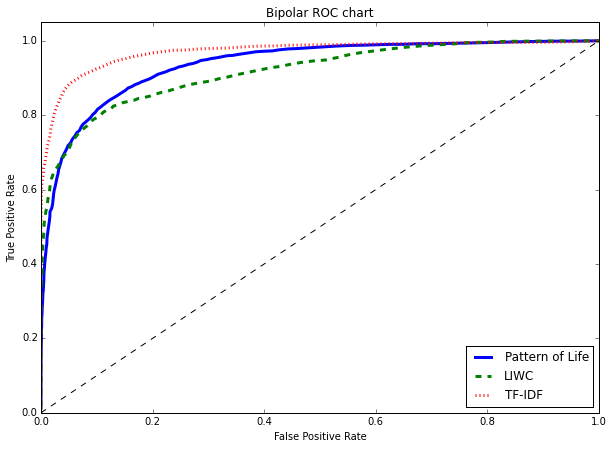

Pattern of Life under curve area: 0.9513296969696968
LIWC under curve area: 0.9327632196969697
TF-IDF under curve area: 0.9703423106060606


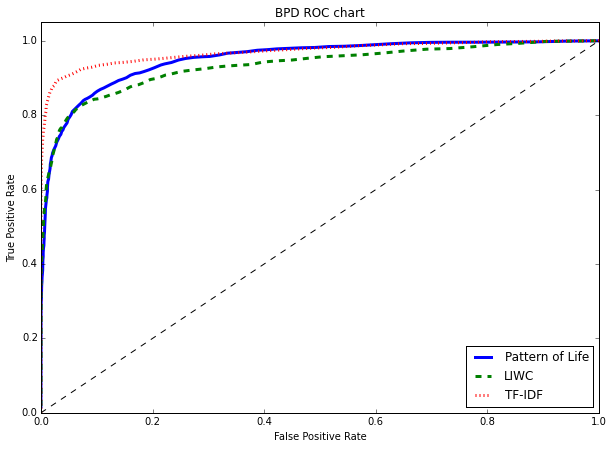

Pattern of Life Average Precision: 0.9076258745563998
LIWC Average Precision: 0.8994644330795993
TF-IDF Average Precision: 0.9623936534273707


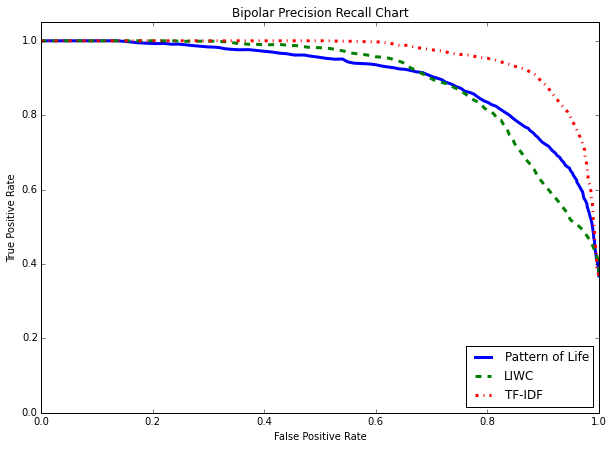

Pattern of Life Average Precision: 0.9169287991323761
LIWC Average Precision: 0.9064920993247483
TF-IDF Average Precision: 0.9604345211542069


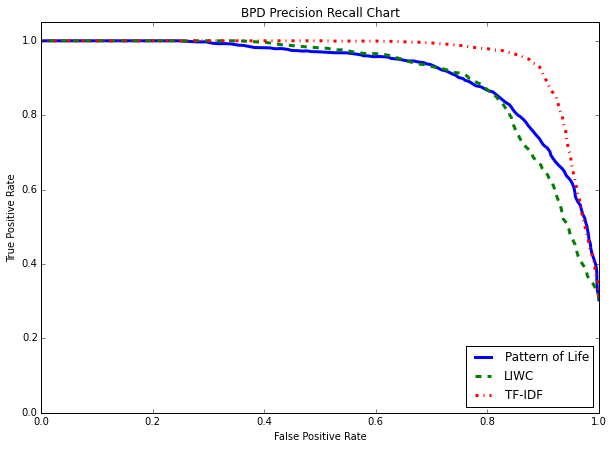

In [15]:
# Precission Recall Chart on 10-fold cross-validation 
index2feature = pol_groups.index2feature

def getSelection(excluded_categories=[], excluded_index=[]):
    selection = []
    for i in range(len(index2feature)):
        name,category =  index2feature[i]
        if any(category == x for x in excluded_categories):
            #removed_features.append(name)
            pass
        elif any(name == x for x in excluded_index):
            #removed_features.append(name)
            pass

        else:                   
            selection.append(i)
    return selection


POL_selection = getSelection(excluded_categories=["LIWC"])
LIWC_selection = getSelection(excluded_categories=["AgeGender", "Social", "Polarity", "Emotions"])


#ROC chart of three models:
def renderROC(scores, labels,disorder ,names, linestyle=['solid','dashed','dotted']):
    fig, ax = plt.subplots()
    for i,(score, label) in enumerate(zip(scores, labels)):
        fpr, tpr, _ = roc_curve(label,score, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=names[i], ls=linestyle[i],linewidth=3)
        print("{} under curve area: {}".format(names[i],roc_auc))

   
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()

names = ["Pattern of Life", "LIWC", "TF-IDF"]
classifier  = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=128)
name = "Bipolar"
n_fold = 100
POL_scores, POL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=POL_selection)
LIWC_scores, LIWC_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=LIWC_selection)
tfidf_scores, tfidf_labels, _ = tfidf_groups.getLabelsScores(name, classifier,n_fold=n_fold)

bipolar_SCORES = [POL_scores, LIWC_scores, tfidf_scores]
bipolar_LABELS = [POL_labels, LIWC_labels, tfidf_labels]

renderROC(bipolar_SCORES, bipolar_LABELS, name,names)

name = "BPD"
POL_scores, POL_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=POL_selection)
LIWC_scores, LIWC_labels, _ = pol_groups.getLabelsScores(name, classifier,n_fold=n_fold, selection=LIWC_selection)
tfidf_scores, tfidf_labels, _ = tfidf_groups.getLabelsScores(name, classifier,n_fold=n_fold)

BPD_SCORES = [POL_scores, LIWC_scores, tfidf_scores]
BPD_LABELS = [POL_labels, LIWC_labels, tfidf_labels]
renderROC(BPD_SCORES, BPD_LABELS, name,names)
#np.sum(tfidf_labels)

def renderPRC(scores, labels,disorder ,names, linestyle=['solid','dashed','dashdot']):
    fig, ax = plt.subplots()
    for i,(score, label) in enumerate(zip(scores, labels)):
        
        precision, recall, _ = precision_recall_curve(label, score, pos_label=1)
        average_precision = average_precision_score(label, score)

        plt.plot(recall, precision, label=names[i], ls=linestyle[i],linewidth=3)
        print("{} Average Precision: {}".format(names[i],average_precision))

   

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Precision Recall Chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()
renderPRC(bipolar_SCORES, bipolar_LABELS, "Bipolar",names)
renderPRC(BPD_SCORES, BPD_LABELS, "BPD",names)

### Render the selection bias test charts

Disorder      Pattern of Life      LIWC     TF-IDF
----------  -----------------  --------  ---------
Bipolar              0.773333  0.223333  0.222222
BPD                  0.818182  0.482727  0.0909091


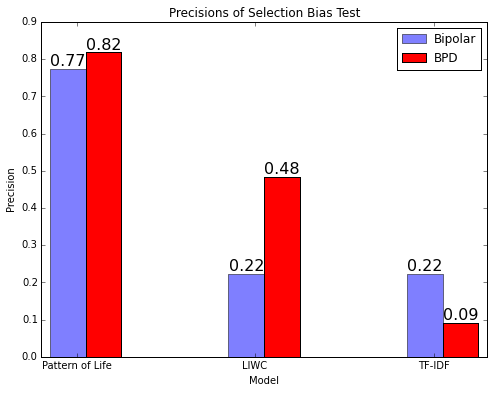

In [20]:
# 100 times of Selection Bias Testing
index2feature = pol_groups.index2feature
removed_features = []
def getSelection(excluded_categories=[], excluded_index=[]):
    selection = []
    for i in range(len(index2feature)):
        name,category =  index2feature[i]
        if any(category == x for x in excluded_categories):
            removed_features.append(name)
            
        elif any(name == x for x in excluded_index):
            removed_features.append(name)

        else:                   
            selection.append(i)
    return selection


POL_selection = getSelection(excluded_categories=["LIWC"])
LIWC_selection = getSelection(excluded_categories=["AgeGender", "Social", "Polarity", "Emotions"])
n_fold = 100
POL_bipolar_scores = []
LIWC_bipolar_scores = []
TFIDF_bipolar_scores = []

POL_BPD_scores = []
LIWC_BPD_scores = []
TFIDF_BPD_scores = []

for i in range(n_fold):

    POL_bipolar_scores .append(1 - np.mean(pol_groups.classify("Bipolar", "bipolar Expert", selection = POL_selection)))
    LIWC_bipolar_scores .append(1 - np.mean(pol_groups.classify("Bipolar", "bipolar Expert", selection = LIWC_selection)))

    TFIDF_bipolar_scores .append(1 - np.mean(tfidf_groups.classify("Bipolar", bipolar_experts)))

    POL_BPD_scores .append(1 - np.mean(pol_groups.classify("BPD", "BPD Expert", selection = POL_selection)))
    LIWC_BPD_scores .append(1 - np.mean(pol_groups.classify("BPD", "BPD Expert", selection = LIWC_selection)))
    TFIDF_BPD_scores .append(1 - np.mean(tfidf_groups.classify("BPD", BPD_experts)))
    


    

headers = ["Disorder","Pattern of Life", "LIWC", "TF-IDF"]
content_bipolar = ["Bipolar",np.mean(POL_bipolar_scores),np.mean(LIWC_bipolar_scores) ,np.mean(TFIDF_bipolar_scores)] 
content_BPD = ["BPD",np.mean(POL_BPD_scores),np.mean(LIWC_BPD_scores) ,np.mean(TFIDF_BPD_scores)] 
contents = [content_bipolar, content_BPD]
#print(bipolar_result_all, BPD_result_all)
#print(bipolar_result_selected, BPD_result_selected)
print(tabulate(contents, headers=headers))


bipolar_precisions = [np.mean(POL_bipolar_scores),np.mean(LIWC_bipolar_scores) ,np.mean(TFIDF_bipolar_scores)]
BPD_precisions = [np.mean(POL_BPD_scores),np.mean(LIWC_BPD_scores) ,np.mean(TFIDF_BPD_scores)]
precisions = [bipolar_precisions, BPD_precisions]


def renderBarChart(precisions):
    rcParams['figure.figsize'] = 8, 6
    n_groups = 3

  

    fig, ax = plt.subplots()
    
    index = np.arange(n_groups)
    bar_width = 0.2

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax.bar(index +0.05, precisions[0], bar_width,
                     alpha=0.5,
                     color='b',
                     label='Bipolar')

    rects2 = ax.bar(index + bar_width+0.05, precisions[1], bar_width,
                     
                     color='r',
                     label='BPD')
    #rects1.set_hatch('-')

    
    for rects in [rects1, rects2]:
        for rect in rects:
            
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1*height,
                "{0:.2f}".format(float(height)),
                ha='center', va='bottom',  fontsize=16)

    #ax.set_xticklabels("", fontsize=20)
    plt.xlabel('Model')
    plt.ylabel('Precision')
    plt.title('Precisions of Selection Bias Test  ')
    
    plt.xticks(index + bar_width, ('Pattern of Life', 'LIWC', 'TF-IDF'))
    plt.legend()


   
    #rcParams['figure.figsize'] = 2.5, 1.75
    plt.show()
    rcParams['figure.figsize'] = 10, 7


renderBarChart(precisions)

### Render the charts of limited tweets test

In [ ]:
#Limited Data Performance Testing
index2feature = pol_groups.index2feature
removed_features = []
def getSelection(excluded_categories=[], excluded_index=[]):
    selection = []
    for i in range(len(index2feature)):
        name,category =  index2feature[i]
        if any(category == x for x in excluded_categories):
            removed_features.append(name)
        elif any(name == x for x in excluded_index):
            removed_features.append(name)

        else:                   
            selection.append(i)
    return selection


POL_selection = getSelection(excluded_categories=["LIWC"])
LIWC_selection = getSelection(excluded_categories=["AgeGender", "Social", "Polarity", "Emotions"])
#n_fold = 30
#disorder = "Bipolar"
access_points = [1,2,3,4,5,6,7,8,9,10,13,15,20,30,40,50,65,80,100,125,150,175,200,225,250,300,325,350,\
                 400,450,500,550,600,650,700,750,800,850,900,950,1000]


#access_points = [10,100,1000]

#access_points = [5,100]

#Precision chart of three models:
def renderPrecisionsChart(access_points, disorder,n_fold):
    POL_precisions = []
    LIWC_precisions = []
    tfidf_precisions =[]
    for tail_k in access_points:
        #pol_groups.re_init(tail_k)
        POL_precisions.append(pol_groups.getPrecision(disorder, tail_k=tail_k,selection = POL_selection,n_fold=n_fold))
        LIWC_precisions.append(pol_groups.getPrecision(disorder, tail_k=tail_k,selection = LIWC_selection,n_fold=n_fold))
        tfidf_precisions.append(tfidf_groups.getPrecision(disorder,tail_k=tail_k,n_fold=n_fold))



    plt.plot(access_points, POL_precisions, label="Pattern of Life", ls="solid",linewidth=3)
    plt.plot(access_points,LIWC_precisions, label="LIWC", ls="dashed",linewidth=3)
    plt.plot(access_points, tfidf_precisions, label="TF-IDF", ls='dashdot',linewidth=3)
    plt.ylim([0.5, 1.05])
    plt.xlim([1, 1000])
    plt.xlabel('Acessible Tweets')
    plt.ylabel('Precision')
    plt.title('{} Limited Tweets Testing'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()
    return (POL_precisions, LIWC_precisions, tfidf_precisions)


bipolar_all_precisions = renderPrecisionsChart(access_points, "Bipolar",n_fold=30)
BPD_all_precisions = renderPrecisionsChart(access_points, "BPD",n_fold=30)




In [27]:
#Classifier Comparison 

index2feature = pol_groups.index2feature

def getSelection(excluded_categories=[], excluded_index=[]):
    selection = []
    for i in range(len(index2feature)):
        name,category =  index2feature[i]
        if any(category == x for x in excluded_categories):
            pass
        elif any(name == x for x in excluded_index):
            pass

        else:                   
            selection.append(i)
    return selection

POL_selection =  getSelection(excluded_categories=["LIWC"])

forest = RandomForestClassifier(n_jobs=-1, n_estimators=1024)
SGC  = SGDClassifier(n_jobs=-1,loss="log")
NB = GaussianNB()
svm = SVC(probability=True,gamma= 0.01)

names = ["SVM","Random Forest","Navie Bayes", "Linear Regression" ]

def renderPRC_classifiers(disorder, classifiers ,names, linestyle=['solid','dashed', 'dashdot', 'dotted'],n_fold=10):
    
    fig, ax = plt.subplots()
     
    Scores, Labels, = pol_groups.getLabelsScores_multiClassifiers(disorder, classifiers,n_fold, POL_selection)
    for i in range(len(classifiers)):
        precision, recall, _ = precision_recall_curve(Labels[i], Scores[i], pos_label=1)
        average_precision = average_precision_score(Labels[i], Scores[i])
        plt.plot(recall, precision, label=names[i], ls=linestyle[i],linewidth=3)
        print("{} Average Precision: {}".format(names[i],average_precision))

   

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Precision Recall Chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()
classifiers = [svm,best_forest_Bipolar, NB,SGC,]
renderPRC_classifiers("Bipolar",classifiers,names, n_fold=100)
classifiers = [svm,best_forest_BPD, NB,SGC,]

renderPRC_classifiers("BPD",classifiers,names, n_fold=100)  










NameError: name 'best_forest_Bipolar' is not defined

In [ ]:

POL_selection =  getSelection(excluded_categories=["LIWC"])

forest = RandomForestClassifier(n_jobs=-1, n_estimators=1024)
SGC  = SGDClassifier(n_jobs=-1,loss="log")
NB = GaussianNB()
svm = SVC(probability=True)
classifiers = [svm,best_forest, NB,SGC,]
names = ["SVM","Random Forest","Navie Bayes", "Linear Regression" ]


def renderROC_classifiers(disorder, classifiers ,names, linestyle=['solid','dashed', 'dashdot', 'dotted'],n_fold=10):
    
    fig, ax = plt.subplots()
     
    Scores, Labels, = pol_groups.getLabelsScores_multiClassifiers(disorder, classifiers,n_fold, POL_selection)
    for i in range(len(classifiers)):
        fpr, tpr, _ = roc_curve(Labels[i], Scores[i], pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=names[i], ls=linestyle[i],linewidth=3)
        print("{} under curve area: {}".format(names[i],roc_auc))

   
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Precision Recall Chart'.format(disorder))
    plt.legend(loc="lower right")

    plt.show()
renderROC_classifiers("Bipolar",classifiers,names, n_fold=100)
renderROC_classifiers("BPD",classifiers,names, n_fold=100)  



In [26]:
3

3

In [ ]:
maxmin_scaler = MinMaxScaler()
bipolar_X, _ = pol_groups.getLabeledData("Bipolar", selection=online_selection)
BPD_X, _ = pol_groups.getLabeledData("BPD", selection=online_selection)
X = np.concatenate((bipolar_X, BPD_X))
maxmin_scaler.fit(X)
joblib.dump(maxmin_scaler,"models/scaler/scaler")